In [2]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import os

def absoluteFilePaths(directory):
    for root, dirs, files in os.walk(os.path.abspath(directory)):
        return [os.path.join(root, file) for file in files]



def get_resilience(directory):
    results_files = absoluteFilePaths(directory)
    df = pd.DataFrame()
    for file in results_files:
        temp_df = pd.read_csv(file, index_col=0).groupby(['Dimension', 'Aspect', 'Threshold']).mean().reset_index()
        temp_df = temp_df[['Dimension', 'Aspect', 'Threshold', 'Reliability']].rename(columns={'Reliability': 'Resilience'})
        temp_df['Network'] = file.split('_')[1]
        df = df.append(temp_df, ignore_index=True)
    return df

In [9]:
#raw_data = get_resilience('./results')
raw_data = pd.read_csv('results/resilience_normal.csv')
print(raw_data.head())

       Network         S        Sp         N        Np   Overall
0  variant_100  0.755866  0.279071  0.433360  0.287219  0.422158
1  variant_101  0.710036  0.191053  0.679473  0.397434  0.504533
2  variant_102  0.661038  0.268111  0.462709  0.245712  0.378486
3  variant_103  0.765777  0.195705  0.340097  0.177364  0.319753
4  variant_104  0.604322  0.117160  0.193510  0.088800  0.143824


In [ ]:
c1 = (raw_data['Dimension'] == 'Magnitude')
c2 = (raw_data['Aspect'] == 'Service') 
c3 = (raw_data['Threshold'] == 0)
df = raw_data[c1 & c2 & c3].set_index('Network')
print(df['Resilience'].min()-df['Resilience'].max())


In [4]:
def get_series(dim, aspect, threshold):
    c1 = (raw_data['Dimension'] == dim)
    c2 = (raw_data['Aspect'] == aspect) 
    c3 = (raw_data['Threshold'] == threshold)
    df = raw_data[c1 & c2 & c3].set_index('Network')
    return df['Resilience']

print(raw_data['Dimension'].unique())
series = {'S': get_series('Magnitude', 'Service', 0),
          r'$S_{peak}$': get_series('Peak', 'Service', 0),
          'N': get_series('Magnitude', 'Spatial', 0),
          r'$N_{peak}$': get_series('Peak', 'Spatial', 0)}
df = pd.DataFrame(series)
print(df.head())

NameError: name 'raw_data' is not defined

In [65]:
from itertools import combinations
df = pd.read_csv('results/resilience_normal.csv')
df = df.set_index('Network')
df = df.drop('Overall',axis=1) 
columns = df.columns
scaler = MinMaxScaler()
for col in columns:
    df[col] = scaler.fit_transform(df[[col]])

graph_combinations = [comb for comb in combinations(columns, 2)]



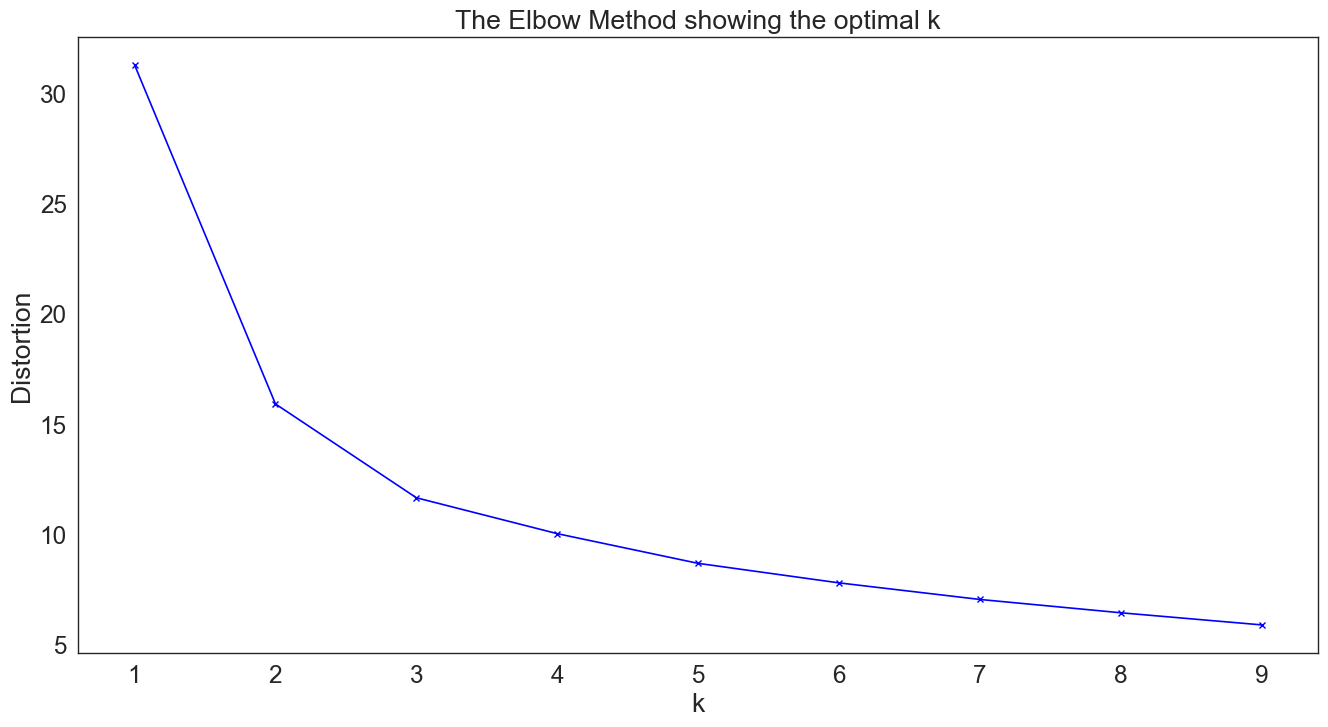

In [66]:
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df[columns])
    distortions.append(kmeanModel.inertia_)
    

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [67]:
km = KMeans(n_clusters=3)
y_predict = km.fit_predict(df[columns])
df['cluster'] = y_predict

In [68]:
groups = df.groupby('cluster').mean().sum(axis=1)
for cluster, performance in zip(groups.sort_values().iteritems(), ['Low performance', 'Medium performance', 'High performance']):
    df.loc[df['cluster'] == cluster[0], 'cluster'] = performance


print(df.head())

                    S        Sp         N        Np             cluster
Network                                                                
variant_100  0.755866  0.317418  0.433360  0.265179  Medium performance
variant_101  0.710036  0.217305  0.679473  0.366937  Medium performance
variant_102  0.661038  0.304952  0.462709  0.226857  Medium performance
variant_103  0.765777  0.222596  0.340097  0.163753     Low performance
variant_104  0.604322  0.133259  0.193510  0.081985     Low performance


C:\Users\elir\AppData\Local\Temp\ipykernel_15524\4108792578.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cluster, performance in zip(groups.sort_values().iteritems(), ['Low performance', 'Medium performance', 'High performance']):


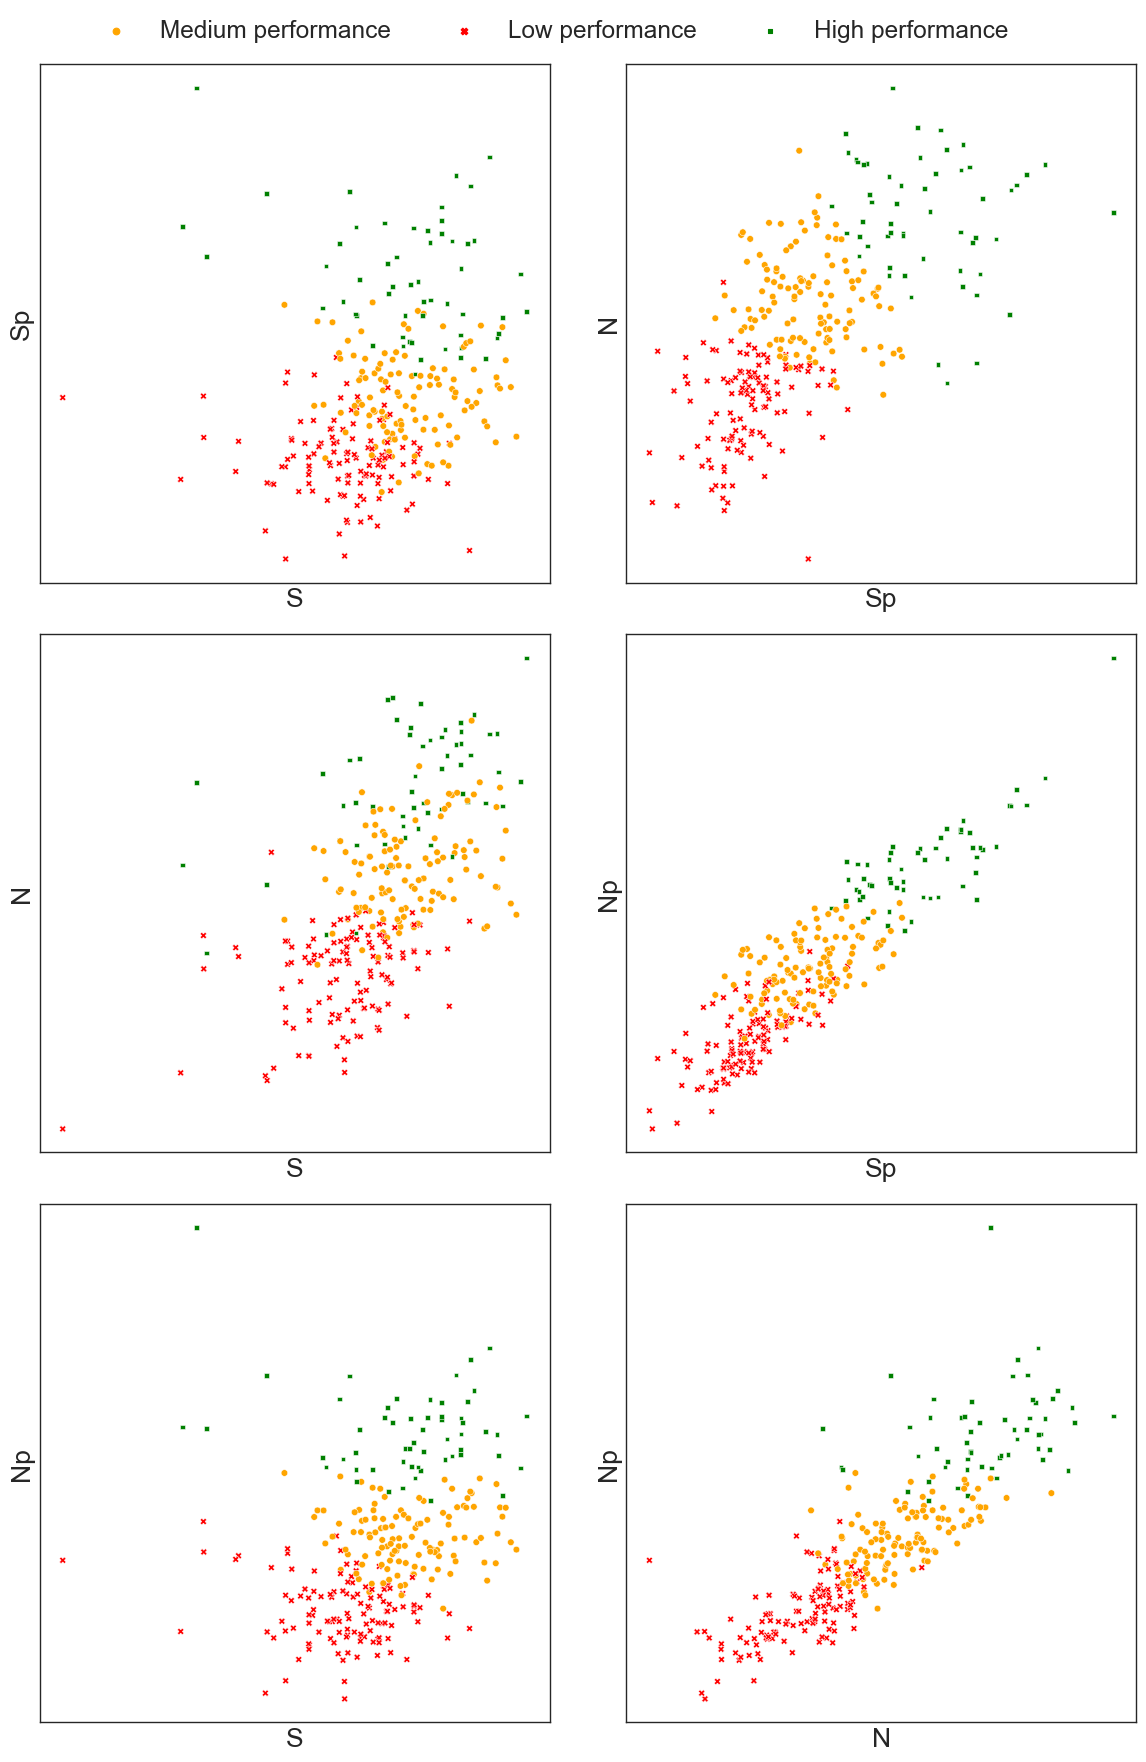

                    S        Sp         N        Np             cluster
Network                                                                
variant_100  0.755866  0.317418  0.433360  0.265179  Medium performance
variant_101  0.710036  0.217305  0.679473  0.366937  Medium performance
variant_102  0.661038  0.304952  0.462709  0.226857  Medium performance
variant_103  0.765777  0.222596  0.340097  0.163753     Low performance
variant_104  0.604322  0.133259  0.193510  0.081985     Low performance
...               ...       ...       ...       ...                 ...
variant_97   0.730387  0.285031  0.465564  0.220056  Medium performance
variant_98   0.694806  0.214162  0.397213  0.161207     Low performance
variant_99   0.771438  0.388803  0.488281  0.372206  Medium performance
variant_9    0.879982  0.792008  0.793688  0.720230    High performance
benchmark    0.287690  1.000000  0.736190  1.000000    High performance

[295 rows x 5 columns]


In [106]:
sns.set_style("whitegrid")
palette = {'Low performance': 'Red', 'Medium performance': 'Orange', 'High performance': 'Green'}



plt.rcParams['figure.figsize'] = [12, 18]
sns.set_style("white")
sns.set_palette("bright")
#palette = sns.color_palette("Spectral", as_cmap=True)
fig, axs = plt.subplots(3, 2)
i = 0
for x, ax_x in enumerate(axs[0, :]):
    for y, ax_y in enumerate(axs[:, 0]):
        if x == 0 and y == 0:
            sns.scatterplot(ax= axs[x, y], x=df[graph_combinations[i][0]], y= df[graph_combinations[i][1]], hue=df['cluster'], style=df['cluster'], palette =palette)
            sns.move_legend(axs[x, y], "lower center", bbox_to_anchor=(1, 1), ncol=4, title=None, frameon=False)
        else:
            sns.scatterplot(ax= axs[y, x], x=df[graph_combinations[i][0]], y= df[graph_combinations[i][1]], hue=df['cluster'], style=df['cluster'], palette =palette, legend = False)
        axs[y, x].set_xticks([])
        axs[y, x].set_yticks([])

        i += 1

        
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.1)
#plt.savefig('scatter.png', bbox_inches='tight')
plt.show()

print(df)


In [70]:
attributes_data = pd.read_csv('results/attributes_normal.csv')
attributes_data = attributes_data.set_index('Network')

attributes_data['cluster'] = df['cluster']

print(attributes_data)

                    d         a        cc        Cd        Gd        Gr  \
Network                                                                   
variant_100  0.263158  0.100428  0.450667  0.033675  0.657851  0.642127   
variant_101  0.368421  0.255050  0.673282  0.288121  0.609046  0.621711   
variant_102  0.378947  0.143039  0.555931  0.043958  0.573825  0.560109   
variant_103  0.147368  0.122558  0.220513  0.019694  0.719504  0.732025   
variant_104  0.352632  0.144922  0.643360  0.030437  0.676438  0.687657   
...               ...       ...       ...       ...       ...       ...   
variant_96   1.000000  0.942559  0.831046  0.104595  0.000000  0.000000   
variant_97   0.400000  0.219926  0.648309  0.175021  0.283755  0.276973   
variant_98   0.226316  0.179293  0.265157  0.081336  0.420903  0.439618   
variant_99   0.178947  0.175102  0.237651  0.023629  0.784070  0.765329   
variant_9    0.078947  0.038514  0.118970  0.568310  0.808652  0.789324   

                   Bd   

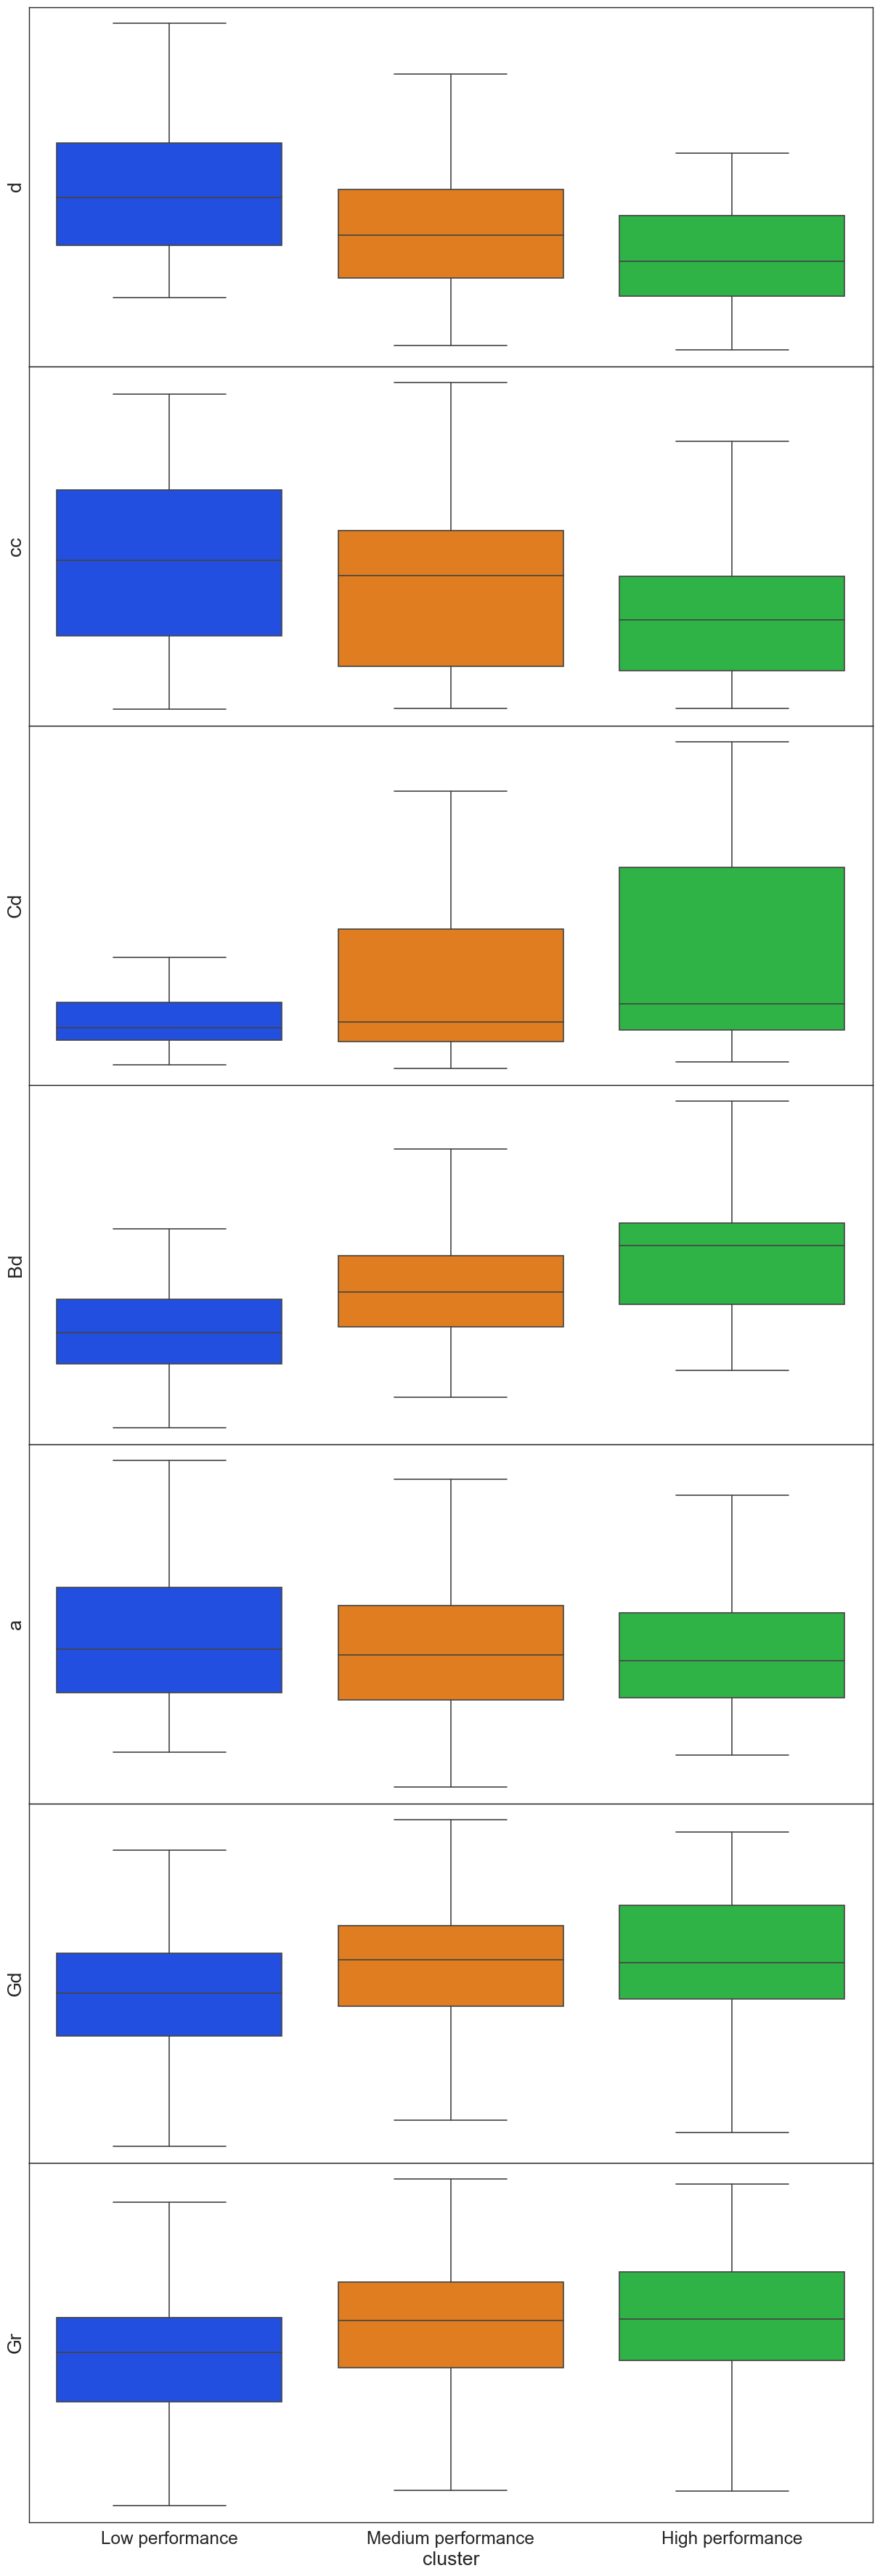

In [87]:
plt.rcParams['figure.figsize'] = [15, 45]
sns.set_style("white")
sns.color_palette()

columns = ['Link density', 'Clustering Coefficient', 'Central Point of Dominance', 'Bridge density']
columns = ['d', 'cc', 'Cd', 'Bd', 'a', 'Gd', 'Gr']

attributes_data['Sort'] = 0
attributes_data.loc[attributes_data['cluster'] == 'Medium performance', 'Sort'] = 1
attributes_data.loc[attributes_data['cluster'] == 'High performance', 'Sort'] = 2

#attributes_data.sort_values('Sort', inplace=True, ascending=True)

fig, axs = plt.subplots(len(columns), 1)
for x, ax_x in enumerate(axs[:]):
    #sns.boxplot(data=attributes_data, x='Sort', y=columns[x], ax=axs[x], palette='Greys', showfliers = False)
    sns.boxplot(data=attributes_data, x='cluster', y=columns[x], ax=axs[x], showfliers = False, order=['Low performance', 'Medium performance', 'High performance'])
    axs[x].set_yticks([])
    #axs[x].set_xticks(['Low performance', 'Medium performance', 'High performance'])
    

plt.subplots_adjust(wspace=1, hspace=0)
#plt.savefig('box_group.png', bbox_inches='tight')
plt.show()